Baseline text preprocessing, topic modeling, and evaluation for text of existing UIUC CS 410 projects.
To get an idea of how existing topic-modeling code works on this dataset.

Most code taken from: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/ and https://towardsdatascience.com/topic-modeling-with-gensim-a5609cefccc

Required packages:
* string
* pandas
* pprint
* gensim
* spacy
* pyLDAvis
* matplotlib

Before running code, download the spaCy package's small English language model from a Python terminal:
```
python -m spacy download en_core_web_sm
```

In [ ]:
# Ignore deprecation warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
# Import required libraries

import re
import string
import pandas as pd
from pprint import pprint

# NLTK for stopwords
from nltk.corpus import stopwords

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.models import Phrases
from gensim.models.phrases import Phraser
#from gensim.utils import simple_preprocess
#from gensim.parsing import strip_punctuation, strip_non_alphanum, strip_multiple_whitespaces, remove_stopwords, strip_short
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel

# spaCy for lemmatization
import spacy
# Load spaCy small English-language model
nlp = spacy.load("en_core_web_sm")

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\ktuoh\anaconda3\envs\py388\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


Define parts of speech to retain in cleaned text.

By default, retain adjectives, adverbs, nouns, proper nouns, verbs, and "other".
This removes adpositions, auxiliaries, conjunctions, determiners, interjections, standalone numbers, particles, punctuation, symbols and spaces.

A complete list of spaCy POS tags may be found at https://machinelearningknowledge.ai/tutorial-on-spacy-part-of-speech-pos-tagging

In [4]:
# Parts of speech to retain in processed text
pos_to_retain = ["ADJ","ADV","NOUN","PROPN","VERB","X"]

Load stopword list

In [5]:
stop_words = stopwords.words('english')

Load list of high-usage words. These occur frequently in CS 410 project documentation but are not helpful in distinguishing topics.

In [12]:
high_usage_word_df = pd.read_csv("./highusage_words.txt", sep="\t", names=["high_usage_word"], header=None)
high_usage_word_list = high_usage_word_df["high_usage_word"].to_list()

high_usage_word_list

['fork',
 'github',
 'repository',
 'week',
 'course',
 'project',
 'overview',
 'courseproject',
 'link',
 'work',
 'http',
 'https',
 'students',
 'student',
 'papers',
 'paper',
 'illinois',
 'teams',
 'team',
 'download',
 'file',
 'code',
 'install',
 'coursera',
 'microsoft',
 'com',
 'web',
 'python',
 'www',
 'java',
 'following',
 'going',
 'use',
 'user',
 'data',
 'using',
 'used',
 'training',
 'word',
 'google',
 'also',
 'based',
 'captain',
 'would',
 'could',
 'should',
 'git',
 'pip',
 'make',
 'update',
 'version',
 'command',
 'new',
 'list',
 'name']

Custom preprocessing routines

* Remove email addresses
* Remove URLS
* Remove frequent words that don't help discriminate CS 410 topics such as "project", "install", etc.
* Remove punctuation
* Remove standalone numbers like 2 or 2.01

Assume that text has already been tokenized.

In [47]:
def remove_email_addrs(token_list):
    """
    Remove email addresses from the given list of tokens.
    """
    return [token for token in token_list if not re.search(r"^\s*[\w\.-]+@[\w\.-]+\s*$", token)]
    
def remove_urls(token_list):
    """
    Remove URLs from the given list of tokens.
    """
    return [token for token in token_list if not re.search(r"^\s*\S*https?:\S*\s*$", token)]
    
def remove_freq_words(token_list):
    """
    Remove words that occur universally in CS 410 project documents such as "project", "install", etc.
    """
    return [token for token in token_list if token not in high_usage_word_list]

def remove_standalone_punctuation(token_list):
    """
    Remove punctuation from the given list of tokens.
    Note that this only affects single-character tokens.
    """
    return [token for token in token_list if token not in string.punctuation]

def is_float(input_string):
    """
    Indicates whether the given string is a floating-point number.
    Helpful in removing standalone numbers from strings without
    affecting digits embedded in words, like "word2vec".
    
    Code borrowed from https://stackoverflow.com/questions/47270001/removing-stand-alone-numbers-from-string-in-python
    """
    try:
        float(input_string)
        return True
    except ValueError:
        return False

def remove_standalone_numbers(token_list):
    """
    Remove standalone numbers from the given text list of tokens.
    Leave digits embedded in words in place, like "word2vec".

    Code borrowed from https://stackoverflow.com/questions/47270001/removing-stand-alone-numbers-from-string-in-python
    """
    return [token for token in token_list if not is_float(token)]

Define routines to:
* tokenize strings and convert to lowercase
* perform POS tagging and lemmatization
* remove stopwords

In [41]:
def lemmatize_and_lowercase(doc_string):
    """
    Given a string of text, return a list of lemmatized, lowercase tokens.
    Use pos_to_retain to restrict the list to the desired POS types.
    To retain all POS types, use an empty list.
    """
    doc = nlp(doc_string)
    if (pos_to_retain == []):
        return [token.lemma_.lower() for token in doc]
    else:
        return [token.lemma_.lower() for token in doc if token.pos_ in pos_to_retain]

def remove_stopwords(token_list):
    """
    Remove stopwords from the given list of tokens.
    """
    return [token for token in token_list if token not in stop_words]

Read data file. This is a tab-delimited file of project URLs and text.

For each URL, the project text appears in a single line. Whitespace has been normalized and Unicode characters have been converted to their closest ASCII equivalents.

In [39]:
project_text_df = pd.read_csv("../collect_data/project_text.tsv", sep="\t")
project_text_df.head()

,project_url,file_text
0,https://github.com/17JamesH/CourseProject,Project Progress Report Team Member Task Progr...
1,https://github.com/97agupta/CourseProject,Team 'Buddie' Project Proposal 1. What are the...
2,https://github.com/AShipway/CourseProject,Aaron Shipway CS 410 Fall '21 Project Progress...
3,https://github.com/AlexZurski/CourseProject,Alexander Zurawski azuraws2 CS 410 11/15/2021 ...
4,https://github.com/AnantSharma18/CourseProject,Page 1 of 2 Project Progress Report Anant Ashu...


Tokenize each project's text, perform lemmatization, and retain desired POS types.

In [42]:
project_text_df["lemmatized_text"] = project_text_df["file_text"].map(lemmatize_and_lowercase)
project_text_df.head()

,project_url,file_text,lemmatized_text
0,https://github.com/17JamesH/CourseProject,Project Progress Report Team Member Task Progr...,"[project, progress, report, team, member, task..."
1,https://github.com/97agupta/CourseProject,Team 'Buddie' Project Proposal 1. What are the...,"[team, buddie, project, proposal, name, netids..."
2,https://github.com/AShipway/CourseProject,Aaron Shipway CS 410 Fall '21 Project Progress...,"[aaron, shipway, cs, fall, ', project, progres..."
3,https://github.com/AlexZurski/CourseProject,Alexander Zurawski azuraws2 CS 410 11/15/2021 ...,"[alexander, zurawski, azuraws2, cs, cs410, fin..."
4,https://github.com/AnantSharma18/CourseProject,Page 1 of 2 Project Progress Report Anant Ashu...,"[page, project, progress, report, anant, ashut..."


Remove stopwords

In [43]:
project_text_df["text_wo_stopwords"] = project_text_df["lemmatized_text"].map(remove_stopwords)
project_text_df[["project_url","lemmatized_text","text_wo_stopwords"]].head()

,project_url,lemmatized_text,text_wo_stopwords
0,https://github.com/17JamesH/CourseProject,"[project, progress, report, team, member, task...","[project, progress, report, team, member, task..."
1,https://github.com/97agupta/CourseProject,"[team, buddie, project, proposal, name, netids...","[team, buddie, project, proposal, name, netids..."
2,https://github.com/AShipway/CourseProject,"[aaron, shipway, cs, fall, ', project, progres...","[aaron, shipway, cs, fall, ', project, progres..."
3,https://github.com/AlexZurski/CourseProject,"[alexander, zurawski, azuraws2, cs, cs410, fin...","[alexander, zurawski, azuraws2, cs, cs410, fin..."
4,https://github.com/AnantSharma18/CourseProject,"[page, project, progress, report, anant, ashut...","[page, project, progress, report, anant, ashut..."


Remove email addresses and URLs

In [45]:
project_text_df["text_wo_emails_urls"] = project_text_df["text_wo_stopwords"].map(remove_email_addrs).map(remove_urls)
project_text_df[["project_url","text_wo_stopwords","text_wo_emails_urls"]].head()

,project_url,text_wo_stopwords,text_wo_emails_urls
0,https://github.com/17JamesH/CourseProject,"[project, progress, report, team, member, task...","[project, progress, report, team, member, task..."
1,https://github.com/97agupta/CourseProject,"[team, buddie, project, proposal, name, netids...","[team, buddie, project, proposal, name, netids..."
2,https://github.com/AShipway/CourseProject,"[aaron, shipway, cs, fall, ', project, progres...","[aaron, shipway, cs, fall, ', project, progres..."
3,https://github.com/AlexZurski/CourseProject,"[alexander, zurawski, azuraws2, cs, cs410, fin...","[alexander, zurawski, azuraws2, cs, cs410, fin..."
4,https://github.com/AnantSharma18/CourseProject,"[page, project, progress, report, anant, ashut...","[page, project, progress, report, anant, ashut..."


Remove standalone punctuation and numbers

In [48]:
project_text_df["text_wo_punct_nums"] = project_text_df["text_wo_emails_urls"].map(remove_standalone_numbers).map(remove_standalone_punctuation)
project_text_df[["project_url","text_wo_emails_urls","text_wo_punct_nums"]].head()

,project_url,text_wo_emails_urls,text_wo_punct_nums
0,https://github.com/17JamesH/CourseProject,"[project, progress, report, team, member, task...","[project, progress, report, team, member, task..."
1,https://github.com/97agupta/CourseProject,"[team, buddie, project, proposal, name, netids...","[team, buddie, project, proposal, name, netids..."
2,https://github.com/AShipway/CourseProject,"[aaron, shipway, cs, fall, ', project, progres...","[aaron, shipway, cs, fall, project, progress, ..."
3,https://github.com/AlexZurski/CourseProject,"[alexander, zurawski, azuraws2, cs, cs410, fin...","[alexander, zurawski, azuraws2, cs, cs410, fin..."
4,https://github.com/AnantSharma18/CourseProject,"[page, project, progress, report, anant, ashut...","[page, project, progress, report, anant, ashut..."


Remove frequent and un-topic-related words from CS 410 project text

In [50]:
project_text_df["text_wo_freq_words"] = project_text_df["text_wo_punct_nums"].map(remove_freq_words)
project_text_df[["project_url","text_wo_punct_nums","text_wo_freq_words"]].head()

,project_url,text_wo_punct_nums,text_wo_freq_words
0,https://github.com/17JamesH/CourseProject,"[project, progress, report, team, member, task...","[progress, report, member, task, progress, rem..."
1,https://github.com/97agupta/CourseProject,"[team, buddie, project, proposal, name, netids...","[buddie, proposal, netids, member, administrat..."
2,https://github.com/AShipway/CourseProject,"[aaron, shipway, cs, fall, project, progress, ...","[aaron, shipway, cs, fall, progress, report, t..."
3,https://github.com/AlexZurski/CourseProject,"[alexander, zurawski, azuraws2, cs, cs410, fin...","[alexander, zurawski, azuraws2, cs, cs410, fin..."
4,https://github.com/AnantSharma18/CourseProject,"[page, project, progress, report, anant, ashut...","[page, progress, report, anant, ashutosh, shar..."


In [51]:
project_text_df["text_wo_freq_words"][11]

['progress',
 'report',
 'plsa',
 'prior',
 'metapy',
 'billy',
 'li',
 'department',
 'computer',
 'science',
 'november',
 'complete',
 'task',
 'extend',
 'plsa',
 'model',
 'include',
 'prior',
 'background',
 'model',
 'pretty',
 'straightforward',
 'step',
 'equation',
 'available',
 'lecture',
 'slide',
 'note',
 'provide',
 'mp3[4',
 'input',
 'fle',
 'read',
 'fashion',
 'similar',
 'sklearn',
 'model',
 'document',
 'label',
 'document',
 'testing',
 'document',
 'read',
 'separately',
 'document',
 'label',
 'compute',
 'prior',
 'probability',
 'topic',
 'background',
 'model',
 'add',
 'model',
 'saving',
 'loading',
 'functionality',
 'functionality',
 'imple-',
 'mente',
 'pickles',
 'library',
 'save',
 'load',
 'compute',
 'class',
 'variable',
 'i.e.',
 'p(w|z',
 'resume',
 'uncompleted',
 'e',
 'algorithm',
 'save',
 'time',
 'recompute',
 'static',
 'variable',
 'prior',
 'probability',
 'background',
 'model',
 'pende',
 'task',
 'integrate',
 'plsa',
 'model',
 'm

Incorporate bigrams.
Borrowed from https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [56]:
# Build bigram model. Set min_count and threshold arbitrarily.
# These are hyperparameters, so would have to be learned to achieve more targeted values.

bigram = Phrases(project_text_df["text_wo_freq_words"].to_list(), min_count=5, threshold=100)
bigram_phraser = Phraser(bigram)

In [60]:
# Add column of project text which includes bigrams.
project_text_df["text_w_bigrams"] = [project_token_list for project_token_list in bigram_phraser[project_text_df["text_wo_freq_words"]]]

In [61]:
project_text_df[["project_url","text_wo_freq_words","text_w_bigrams"]].head()

,project_url,text_wo_freq_words,text_w_bigrams
0,https://github.com/17JamesH/CourseProject,"[progress, report, member, task, progress, rem...","[progress_report, member, task, progress, rema..."
1,https://github.com/97agupta/CourseProject,"[buddie, proposal, netids, member, administrat...","[buddie, proposal, netids_member, administrati..."
2,https://github.com/AShipway/CourseProject,"[aaron, shipway, cs, fall, progress, report, t...","[aaron, shipway, cs, fall, progress_report, ta..."
3,https://github.com/AlexZurski/CourseProject,"[alexander, zurawski, azuraws2, cs, cs410, fin...","[alexander, zurawski, azuraws2, cs, cs410, fin..."
4,https://github.com/AnantSharma18/CourseProject,"[page, progress, report, anant, ashutosh, shar...","[page, progress_report, anant, ashutosh, sharm..."


Build corpus.
Use the version of the project text which includes bigrams.

In [62]:
doc_list = project_text_df["text_w_bigrams"].to_list()

# Create dictionary
id2word = corpora.Dictionary(doc_list)

# Generate corpus
corpus = [id2word.doc2bow(doc_text) for doc_text in doc_list]


In [63]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('25h', 1),
  ('activity', 1),
  ('add', 3),
  ('answer', 1),
  ('api', 4),
  ('application', 4),
  ('area', 4),
  ('attach', 4),
  ('automatically', 2),
  ('available', 2),
  ('aws', 2),
  ('b', 1),
  ('back_end', 4),
  ('base', 4),
  ('basic', 2),
  ('basically', 1),
  ('bathroom', 1),
  ('bedroom', 1),
  ('big', 2),
  ('budget', 1),
  ('call', 2),
  ('care', 1),
  ('check', 1),
  ('chong', 3),
  ('choose', 2),
  ('city', 1),
  ('collect', 1),
  ('commonly', 1),
  ('crawl_redfin.com', 6),
  ('crawler', 3),
  ('create', 8),
  ('currently', 1),
  ('database', 6),
  ('dataset', 3),
  ('datum', 18),
  ('decide', 4),
  ('decision', 2),
  ('define', 1),
  ('detailed_instruction', 1),
  ('difference', 2),
  ('different', 2),
  ('display', 3),
  ('divide', 1),
  ('endpoint', 2),
  ('engine', 3),
  ('enter', 1),
  ('etc', 1),
  ('evaluation', 1),
  ('eventually', 1),
  ('example', 1),
  ('fetch', 2),
  ('finally', 1),
  ('find', 2),
  ('form', 1),
  ('front_end', 5),
  ('function', 3),
  ('

Build example LDA model. Start with 4 topics.

In [70]:
lda_model = LdaModel(corpus=corpus,
                     id2word=id2word,
                     num_topics=4, 
                     random_state=12345,
                     update_every=1,
                     chunksize=10,
                     passes=10,
                     alpha="auto",
                     eta="auto",
                     per_word_topics=True)

In [71]:
pprint(lda_model.print_topics())

[(0,
  '0.012*"hour" + 0.011*"search" + 0.011*"task" + 0.011*"datum" + '
  '0.011*"build" + 0.010*"create" + 0.010*"topic" + 0.010*"sentiment" + '
  '0.009*"dataset" + 0.009*"system"'),
 (1,
  '0.051*"model" + 0.020*"train" + 0.017*"bert" + 0.015*"context" + '
  '0.014*"dataset" + 0.012*"datum" + 0.011*"text" + 0.010*"test" + '
  '0.008*"response" + 0.007*"pattern"'),
 (2,
  '0.018*"model" + 0.012*"text" + 0.011*"review" + 0.011*"document" + '
  '0.008*"result" + 0.008*"set" + 0.008*"collection" + 0.007*"information" + '
  '0.007*"theme" + 0.006*"mining"'),
 (3,
  '0.020*"topic" + 0.012*"meta" + 0.010*"metapy" + 0.010*"run" + 0.007*"slide" '
  '+ 0.007*"time" + 0.005*"lda" + 0.005*"instal" + 0.004*"value" + '
  '0.004*"document"')]


Try a series of models with different topic counts, and use topic coherence to determine the best topic count.

Code copied and adapted from https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [75]:
def compute_coherence_values(id2word, corpus, texts, limit, start=2, step=3):
    """
   Generate topic models for a range of topic counts.
   Evaluate coherence for each topic count, and return lists.

    Parameters:
    ----------
    id2word : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus,
                     id2word=id2word,
                     num_topics=num_topics, 
                     random_state=12345,
                     update_every=1,
                     chunksize=10,
                     passes=10,
                     alpha="auto",
                     eta="auto",
                     per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=id2word, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [76]:
model_list, coherence_values = compute_coherence_values(id2word=id2word, corpus=corpus, texts=project_text_df["text_w_bigrams"].to_list(), limit=40, start=2, step=3)

Chart topic coherence for the model collection.

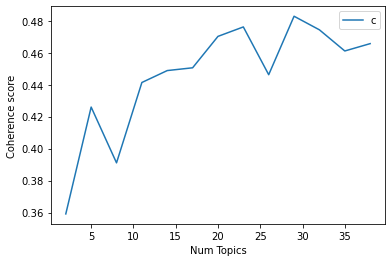

In [78]:
limit=40; start=2; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

Print the coherence scores

In [79]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3591
Num Topics = 5  has Coherence Value of 0.426
Num Topics = 8  has Coherence Value of 0.3911
Num Topics = 11  has Coherence Value of 0.4414
Num Topics = 14  has Coherence Value of 0.4488
Num Topics = 17  has Coherence Value of 0.4506
Num Topics = 20  has Coherence Value of 0.4702
Num Topics = 23  has Coherence Value of 0.4761
Num Topics = 26  has Coherence Value of 0.4462
Num Topics = 29  has Coherence Value of 0.4828
Num Topics = 32  has Coherence Value of 0.4743
Num Topics = 35  has Coherence Value of 0.4611
Num Topics = 38  has Coherence Value of 0.4657


Choose the first model that reaches a high coherence value before the values plateau.

View topics for that model.

Note that models with high numbers of topics feature many "topics" for code to train and test CS 410 project models. Many of those models have identical top-ranked terms.

In [86]:
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.049*"model" + 0.027*"topic" + 0.022*"collection" + 0.019*"text" + '
  '0.017*"theme" + 0.016*"mining" + 0.014*"cluster" + 0.014*"set" + '
  '0.008*"document" + 0.008*"common_theme"'),
 (1,
  '0.064*"pattern" + 0.053*"context" + 0.028*"frequent_pattern" + '
  '0.022*"title" + 0.021*"author" + 0.020*"wang" + 0.016*"pa" + '
  '0.011*"default" + 0.011*"transaction" + 0.011*"id"'),
 (2,
  '0.104*"recipe" + 0.046*"ingredient" + 0.028*"reddit" + 0.013*"subreddit" + '
  '0.013*"complexity" + 0.010*"cooking" + 0.010*"praw" + '
  '0.005*"allrecipes.com" + 0.003*"cook" + 0.003*"cuisine"'),
 (3,
  '0.058*"url" + 0.040*"directory" + 0.037*"system" + 0.030*"metapy" + '
  '0.029*"build" + 0.029*"meta" + 0.029*"page" + 0.023*"slide" + 0.018*"add" + '
  '0.016*"run"'),
 (4,
  '0.000*"train_vector" + 0.000*"train_test_split(feature" + '
  '0.000*"userwarning" + 0.000*"use_cuda" + '
  '0.000*"tv.transform(features_final_test).toarray" + 0.000*"tuning.pdf" + '
  '0.000*"tuning.ipynb" + 0.000*"tr

Use pyLDAvis to visualize this model.

In [89]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(optimal_model, corpus, dictionary=optimal_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9      0.318523  0.034652       1        1  44.343451
5      0.287261  0.113476       2        1  20.293820
7      0.270304 -0.082700       3        1  16.289234
0      0.138445 -0.271565       4        1  11.272523
3      0.030518  0.290756       5        1   3.810681
1     -0.076503 -0.075842       6        1   3.301964
6     -0.205408  0.001271       7        1   0.496381
2     -0.200027 -0.001261       8        1   0.190325
8     -0.187704 -0.002929       9        1   0.000544
10    -0.187704 -0.002929      10        1   0.000541
4     -0.187704 -0.002929      11        1   0.000537, topic_info=                  Term         Freq        Total Category  logprob  loglift
336              model  5850.000000  5850.000000  Default   30.000  30.0000
739            context  1233.000000  1233.000000  Default   29.000  29.0000
667              train  1688.000000  1688.000000  Default   28.000  28.0000
1512              bert  1390.000000  1390.000000  Default   27.000  27.0000
662             system  1023.000000  1023.000000  Default   26.000  26.0000
...                ...          ...          ...      ...      ...      ...
25                city     0.000082    16.911827  Topic11   -9.856  -0.1046
26             collect     0.000082   244.110669  Topic11   -9.856  -2.7743
27            commonly     0.000082    15.587089  Topic11   -9.856  -0.0231
28    crawl_redfin.com     0.000082     0.659823  Topic11   -9.856   3.1391
29             crawler     0.000082   110.580814  Topic11   -9.856  -1.9824

[597 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
157       1  0.999291        a.
683       1  0.234966  accuracy
683       3  0.761408  accuracy
1         2  0.999286  activity
2         1  0.255591       add
...     ...       ...       ...
568       3  0.158960      well
568       4  0.025905      well
1335      5  0.999236   windows
482       1  0.833932     write
482       2  0.165848     write

[578 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 6, 8, 1, 4, 2, 7, 3, 9, 11, 5])

Identify the dominant topic in each CS 410 project.

Once again, code borrowed from https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [97]:
def format_topics_docs(ldamodel, corpus, texts):
    # Init output
    doc_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                doc_topics_df = doc_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    doc_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    doc_topics_df = pd.concat([doc_topics_df, contents], axis=1)
    return(doc_topics_df)


df_topic_docs_keywords = format_topics_docs(ldamodel=optimal_model, corpus=corpus, texts=project_text_df["text_w_bigrams"].to_list())

# Format
df_dominant_topic = df_topic_docs_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,9.0,0.4843,"dataset, datum, run, review, sentiment, analys...","[progress_report, member, task, progress, rema..."
1,1,9.0,0.5508,"dataset, datum, run, review, sentiment, analys...","[buddie, proposal, netids_member, administrati..."
2,2,5.0,0.6501,"search, hour, task, query, topic, page, create...","[aaron, shipway, cs, fall, progress_report, ta..."
3,3,5.0,0.6325,"search, hour, task, query, topic, page, create...","[alexander, zurawski, azuraws2, cs, cs410, fin..."
4,4,9.0,0.6262,"dataset, datum, run, review, sentiment, analys...","[page, progress_report, anant, ashutosh, sharm..."
5,5,5.0,0.4903,"search, hour, task, query, topic, page, create...","[paste_cmt, detailed_instruction, activity]"
6,6,5.0,0.7793,"search, hour, task, query, topic, page, create...","[cs410, reddit, recommenders, task, complete, ..."
7,7,9.0,0.6810,"dataset, datum, run, review, sentiment, analys...","[cs, proposal, song, retrieval, sentiment, ana..."
8,8,9.0,0.5192,"dataset, datum, run, review, sentiment, analys...","[progress_report, andrew, sciotti, sciotti2, t..."
9,9,5.0,0.7277,"search, hour, task, query, topic, page, create...","[task, complete, frontend, complete, create, c..."


Display the most representative document for each topic.

In [100]:
doc_topics_sorted_df = pd.DataFrame()

doc_topics_grouped = df_topic_docs_keywords.groupby('Dominant_Topic')

for i, grp in doc_topics_grouped:
    doc_topics_sorted_df = pd.concat([doc_topics_sorted_df, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)
# Reset Index    
doc_topics_sorted_df.reset_index(drop=True, inplace=True)

# Format
doc_topics_sorted_df.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
doc_topics_sorted_df.head(len(doc_topics_sorted_df))

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.6699,"model, topic, collection, text, theme, mining,...","[see, discussion, stat, author, profile, publi..."
1,1.0,0.5710,"pattern, context, frequent_pattern, title, aut...","[function, i.e., scrape, author, title, dblp, ..."
2,5.0,0.8534,"search, hour, task, query, topic, page, create...","[task, complete, mostly, complete, task, scrap..."
3,7.0,0.7751,"model, train, bert, test, text, classification...","[text, classification, sarcasm_detection, uiuc..."
4,9.0,0.8866,"dataset, datum, run, review, sentiment, analys...","[progress, thus_far, a., far, able, preprocess..."
